# Capítulo 6 – Detección de Anomalías con Isolation Forest

En este capítulo se presenta el algoritmo **Isolation Forest**, una técnica no supervisada de detección de anomalías fundamentada en principios estadísticos y estructurales.  
Su principal fortaleza radica en que no requiere datos etiquetados ni un entrenamiento supervisado, lo que lo convierte en una opción idónea en contextos como el presente, donde no se dispone de información fiable que distinga entre observaciones normales y anómalas.

Isolation Forest se basa en la idea de que los puntos anómalos, al estar menos integrados en la distribución general de los datos, pueden **aislarse más fácilmente** a través de divisiones aleatorias del espacio de características.

## ¿Por qué Isolation Forest?

Las razones para emplear Isolation Forest en detección de anomalías incluyen:

- Modelo ligero, interpretable y rápido de entrenar, adecuado para exploración temprana.  
- No necesita etiquetas ni conocimiento experto previo.  
- Se aplica directamente sobre datos multivariantes sin grandes transformaciones.  
- Ha sido validado en múltiples entornos industriales, lo que respalda su aplicabilidad práctica.

## Intuición

Isolation Forest parte de la premisa:

> "Las anomalías son más fáciles de aislar que los puntos normales."

Mientras otros métodos buscan perfilar lo normal, iForest genera particiones aleatorias y mide lo fácil que resulta separar cada observación.  
Las anomalías, por su rareza y diferencias, requieren menos divisiones para quedar aisladas.

## Fundamento Teórico

El algoritmo construye múltiples **árboles binarios aleatorios** (*iTrees*):

- En cada nodo se selecciona aleatoriamente:
  - Una característica.
  - Un valor de corte dentro de su rango.
- El árbol se construye recursivamente hasta aislar un único punto o alcanzar una profundidad máxima.

### Profundidad de aislamiento

Cada observación recorre todos los árboles. La medida clave es la **profundidad media** necesaria para aislarla.  

- Anomalías → caminos cortos.  
- Normales → caminos más largos.  

El score de anomalía se define como:

$$
s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}
$$

donde $E(h(x))$ es la profundidad media y $c(n)$ el valor esperado de la profundidad en un árbol con $n$ puntos.

### Interpretación del score

| Score $s(x)$ | Interpretación                |
|--------------|-------------------------------|
| ≈ 1          | Alta probabilidad de anomalía |
| ≈ 0.5        | Indefinido                    |
| ≈ 0          | Punto normal                  |

## Parámetros clave

- **n_estimators**: número de árboles (típico: 100–256).  
- **max_samples**: número de muestras para construir cada árbol.  
- **max_depth**: profundidad máxima del árbol.  
- **contamination**: fracción estimada de anomalías (en implementaciones prácticas).

## Ventajas

- Escalable a datasets grandes y de alta dimensión.  
- No depende de supuestos estadísticos.  
- No supervisado, apto para entornos sin etiquetas.

## Limitaciones

- Sensible a la elección de `max_samples`.  
- No captura relaciones temporales sin ingeniería de características.  
- Puede no detectar anomalías que consisten en **rupturas de relaciones entre variables** si estas combinaciones no son estadísticamente infrecuentes.

### Ejemplo ilustrativo

En un motor en condiciones normales:  
- A bajas RPM (≈100), la temperatura del refrigerante debería ser baja (≈40 °C).  

Si aparece un punto con:  
- RPM = 100  
- Temperatura = 95 °C  

aunque viole la lógica física, el algoritmo puede no marcarlo como anómalo si existen otros puntos similares en los datos.


## Implementación de un detector con Isolation Forest

Isolation Forest se implementa a partir de la idea de que las anomalías se aíslan con menos particiones.  
El modelo se construye mediante múltiples árboles aleatorios (*iTrees*), y el score de anomalía se calcula a partir de la profundidad media necesaria para aislar cada punto.

A continuación se muestran las piezas fundamentales de la implementación: funciones auxiliares, la definición del árbol base y finalmente la clase `IsolationForest` como detector.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from modelos.datasets_to_parquet import load_project_parquets
from modelos.base import BaseAnomalyDetector

def harmonic_number(n):
    if n <= 1:
        return 0
    return np.log(n) + 0.5772156649

def c_factor(n):
    if n <= 1:
        return 0
    return 2 * harmonic_number(n - 1) - (2 * (n - 1) / n)

#### Comprobación rápida

A continuación se representan \( H(n) \) y \( c(n) \) para distintos tamaños de muestra.  
Esperamos crecimiento **logarítmico suave**, útil como normalizador del score.


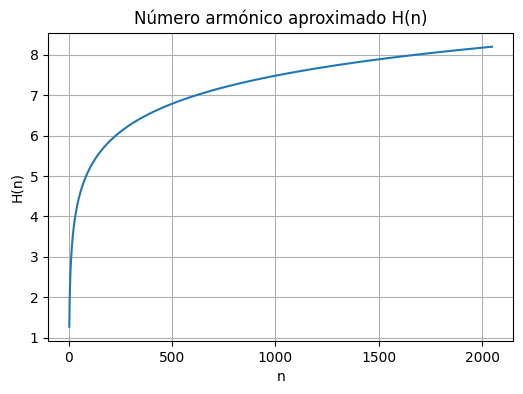

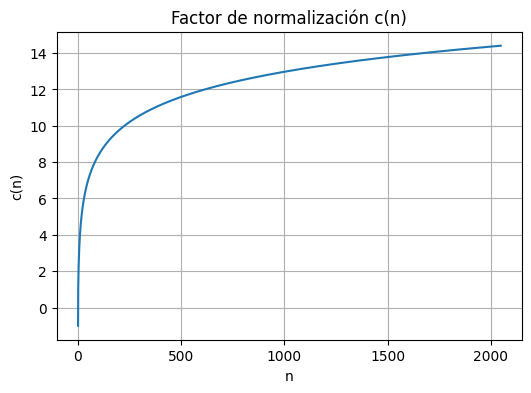

n	H(n)		c(n)
4	1.963510	1.851656
8	2.656657	3.296252
16	3.349804	4.695532
32	4.042952	6.084906
64	4.736099	7.471951
128	5.429246	8.858431
256	6.122393	10.244771
512	6.815540	11.631077
1024	7.508687	13.017374


In [2]:
# Rango de n para visualizar el crecimiento
ns = np.arange(2, 2049)  # desde 2 hasta 2048
H = np.array([harmonic_number(int(n)) for n in ns])
c = np.array([c_factor(int(n)) for n in ns])

# Gráfico 1: H(n)
plt.figure(figsize=(6, 4))
plt.plot(ns, H)
plt.xlabel("n")
plt.ylabel("H(n)")
plt.title("Número armónico aproximado H(n)")
plt.grid(True)
plt.show()

# Gráfico 2: c(n)
plt.figure(figsize=(6, 4))
plt.plot(ns, c)
plt.xlabel("n")
plt.ylabel("c(n)")
plt.title("Factor de normalización c(n)")
plt.grid(True)
plt.show()

# Tabla de referencia para n típicos de sample_size
ns_ref = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
rows = [(n, harmonic_number(n), c_factor(n)) for n in ns_ref]

print("n\tH(n)\t\tc(n)")
for n, h, cf in rows:
    print(f"{n}\t{h:.6f}\t{cf:.6f}")


**Lectura de las figuras**

- Tanto \( H(n) \) como \( c(n) \) muestran un **crecimiento logarítmico**.  
- Esto significa que:
  - **Al inicio** (para valores pequeños de \( n \)) el incremento es muy rápido.  
  - **Después**, conforme \( n \) crece, el aumento se vuelve cada vez más lento y las curvas se van “aplanando”.  
- Gracias a este comportamiento, la **profundidad esperada de los árboles en Isolation Forest** no crece sin control con el tamaño de los datos, sino de manera moderada.  
- En la práctica, esto evita que el score de anomalía dependa directamente del tamaño del dataset y permite comparar resultados entre distintas configuraciones.



### Árbol de aislamiento (`iTree`)

Un `iTree` se construye recursivamente:
- En cada nodo se elige **una característica** al azar y un **valor de corte**.
- Se divide el conjunto en izquierda/derecha y se sigue recursivamente.
- Paramos si alcanzamos una **profundidad máxima** o si hay **≤ 1 muestra**.

👉 En la implementación original de *Isolation Forest*, el corte se hace **uniformemente al azar** en el intervalo `[min, max]` de la característica elegida.  

👉 En esta versión añadimos una **variante**: el corte se puede escoger como un valor aleatorio de entre los **valores reales de la muestra**.  
Esto introduce un cierto sesgo hacia zonas más densas de la distribución (una estimación muy simple de la densidad).


In [3]:
class iTree:
    def __init__(self, data, current_height=0, max_height=np.inf, split_selection_random=True):
        self.n_samples, self.n_features = data.shape
        self.left = None
        self.right = None
        self.split_attr = None
        self.split_value = None
        self.size = self.n_samples
        self.is_leaf = False

        # Criterios de parada
        if current_height >= max_height or self.n_samples <= 1:
            self.is_leaf = True
            return

        # Elegimos una característica al azar
        self.split_attr = np.random.randint(self.n_features)
        # Rango de esa característica
        col = data[:, self.split_attr]
        min_val, max_val = np.min(col), np.max(col)

        # Si no hay variación, hacemos hoja
        if min_val == max_val:
            self.is_leaf = True
            return

        # Valor de corte: uniforme en el rango o aleatorio entre valores observados
        if split_selection_random:
            self.split_value = float(np.random.uniform(min_val, max_val))
        else:
            self.split_value = float(np.random.choice(col))

        # División
        left_mask = col < self.split_value
        self.left = iTree(data[left_mask], current_height + 1, max_height, split_selection_random)
        self.right = iTree(data[~left_mask], current_height + 1, max_height, split_selection_random)


#### Comprobación rápida del nodo raíz

Generamos un dataset sencillo en 2D y entrenamos dos árboles:
1. Con **split uniforme en el rango** (versión original).
2. Con **split tomado de la muestra** (variante añadida).

Visualizamos el corte en cada caso para ver cómo cambia la partición.


Split uniforme:
 - Atributo: 1, Valor: -0.684
Split por muestra:
 - Atributo: 1, Valor: 0.233


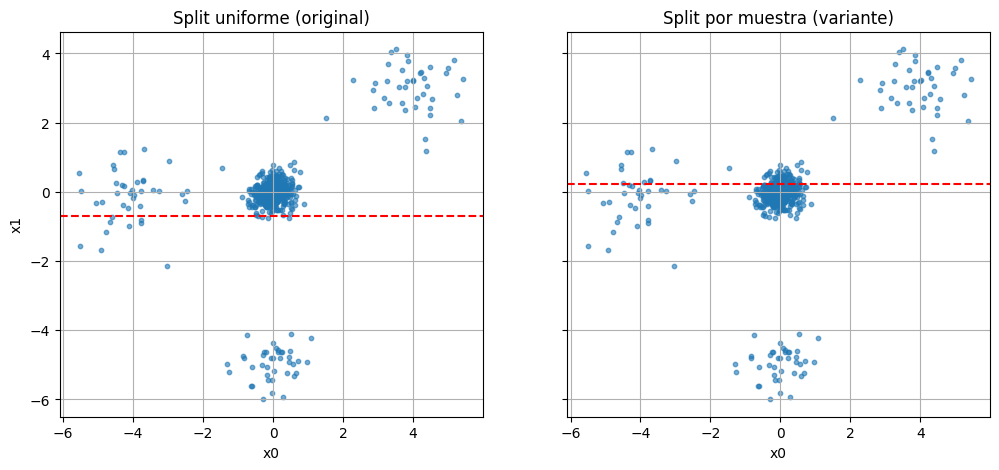

In [4]:
# Dataset 2D exagerado
rng = np.random.default_rng(42)

# Clúster muy denso en el centro
X_center = rng.normal(loc=[0, 0], scale=[0.3, 0.3], size=(400, 2))

# Algunos clústeres dispersos más alejados
X_out1 = rng.normal(loc=[-4, 0], scale=[0.8, 0.8], size=(40, 2))
X_out2 = rng.normal(loc=[4, 3], scale=[1.0, 0.5], size=(40, 2))
X_out3 = rng.normal(loc=[0, -5], scale=[0.6, 0.6], size=(40, 2))

# Concatenar todo
X_demo = np.vstack([X_center, X_out1, X_out2, X_out3])

# Árbol con split uniforme
tree_uniform = iTree(X_demo, current_height=0, max_height=1, split_selection_random=True)

# Árbol con split basado en muestra
tree_sample = iTree(X_demo, current_height=0, max_height=1, split_selection_random=False)

print("Split uniforme:")
print(f" - Atributo: {tree_uniform.split_attr}, Valor: {tree_uniform.split_value:.3f}")
print("Split por muestra:")
print(f" - Atributo: {tree_sample.split_attr}, Valor: {tree_sample.split_value:.3f}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, tree, title in zip(
    axes,
    [tree_uniform, tree_sample],
    ["Split uniforme (original)", "Split por muestra (variante)"]
):
    ax.scatter(X_demo[:,0], X_demo[:,1], s=10, alpha=0.6)
    if tree.split_attr == 0:
        ax.axvline(tree.split_value, ls="--", color="red")
    else:
        ax.axhline(tree.split_value, ls="--", color="red")
    ax.set_title(title)
    ax.set_xlabel("x0"); ax.grid(True)
axes[0].set_ylabel("x1")
plt.show()


**Lectura rápida**

- El **split uniforme** tiende a cortar en cualquier parte del rango, incluso en zonas donde apenas hay datos.  
- El **split basado en la muestra** coloca el corte en valores que realmente aparecen en los datos, lo que hace que la partición esté más alineada con la densidad observada, más amenudo.  

Esta variante no está en el algoritmo original, pero puede hacer que los árboles se ajusten un poco más a la distribución real.


#### Profundidad de camino (`path_length`)

Para evaluar lo “fácil” que es aislar un punto, calculamos la **longitud del camino** que recorre desde la raíz hasta que:
- llega a una **hoja**, y
- añadimos la **corrección** por el tamaño de la hoja con \( c(\text{size}) \) para ajustar la expectativa.

Implementamos `path_length` y lo probamos coloreando los puntos por su longitud de camino en un árbol poco profundo.


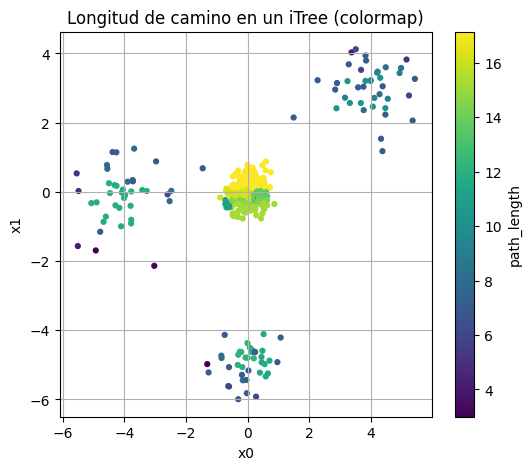

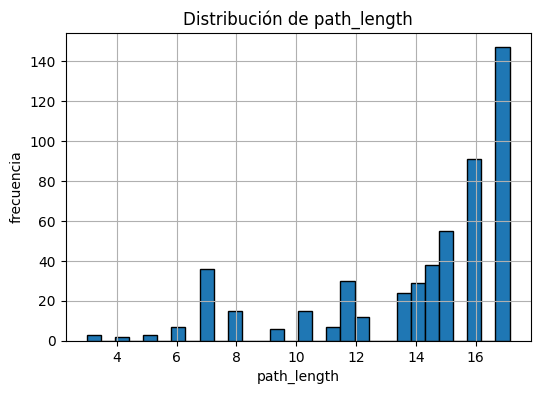

In [5]:
# Añadimos el método a la clase.
def _path_length(self, x, current_height=0):
    if self.is_leaf:
        return current_height + c_factor(self.size)
    if x[self.split_attr] < self.split_value:
        return self.left.path_length(x, current_height + 1)
    else:
        return self.right.path_length(x, current_height + 1)

setattr(iTree, "path_length", _path_length)

# Construimos un árbol con mayor profundidad para ver más variedad
tree_demo2 = iTree(X_demo, current_height=0, max_height=8, split_selection_random=True)

# Longitud de camino por punto
pl = np.array([tree_demo2.path_length(x) for x in X_demo])

# Visualización: puntos coloreados por longitud de camino
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(X_demo[:,0], X_demo[:,1], c=pl, s=12)
ax.set_title("Longitud de camino en un iTree (colormap)")
ax.set_xlabel("x0"); ax.set_ylabel("x1"); ax.grid(True)
cb = plt.colorbar(sc, ax=ax); cb.set_label("path_length")
plt.show()

# También un histograma para ver la distribución
plt.figure(figsize=(6, 4))
plt.hist(pl, bins=30, edgecolor="k")
plt.title("Distribución de path_length"); plt.xlabel("path_length"); plt.ylabel("frecuencia")
plt.grid(True); plt.show()


**Lectura rápida**
- Puntos cercanos a regiones separables suelen requerir **menos splits** → menor `path_length`.
- Puntos integrados en zonas densas necesitan **más splits** → mayor `path_length`.
- Esta medida, normalizada por \( c(n) \) en el bosque, se transformará después en un **score de anomalía**.


## Implementación del detector Isolation Forest

`IsolationForest` ensambla múltiples `iTree` entrenados sobre **submuestras aleatorias** del conjunto de datos.  
Incorpora dos ideas clave:

- **Profundidad máxima** del árbol proporcional a `log2(sample_size)`, lo que controla el crecimiento.
- **Política de umbral**:
  - Si `contamination` es `None` → umbral fijo `τ = 0.5` (criterio clásico del score).
  - Si `contamination ∈ (0,1]` → umbral aprendido como el cuantil `1 - contamination` de los *scores* en entrenamiento.

Además, hereda la **política de corte** del `iTree`:
- `split_selection_random=True`: corte uniforme en `[min, max]` (original).
- `split_selection_random=False`: corte tomado de valores de la muestra (variante con sesgo hacia zonas densas).


In [12]:
import numpy as np
from modelos.base import BaseAnomalyDetector  # ya definida en el notebook anterior

class IsolationForest(BaseAnomalyDetector):
    """
    Detector Isolation Forest con dos políticas de split en cada nodo:
      - split_selection_random=True  -> corte uniforme en [min, max] (original)
      - split_selection_random=False -> corte elegido de la muestra (variante densa)

    Política de umbral:
      - contamination is None  -> τ = 0.5 (fijo)
      - contamination in (0,1] -> τ = quantile_{1-cont}(scores_train)
    """
    def __init__(self,
                 n_trees: int = 100,
                 sample_size: int = 256,
                 split_selection_random: bool = True,
                 contamination: float | None = None):
        self.n_trees = int(n_trees)
        self.sample_size = int(sample_size)
        self.split_selection_random = bool(split_selection_random)
        self.contamination = contamination  # None => τ=0.5 ; (0,1] => cuantil
        self.trees = []
        self.threshold_ = None  # se fijará en fit()

    # Dummy fit: solo guarda los datos
    def fit(self, X):
        X = np.asarray(X)
        self.trees = []          # en la versión real irían los árboles
        self.threshold_ = 0.5    # valor fijo por ahora
        return self

    # Dummy anomaly_score: devuelve ceros
    def anomaly_score(self, X):
        X = np.asarray(X)
        return np.zeros(len(X))

    # Dummy predict: compara scores con threshold_
    def predict(self, X):
        scores = self.anomaly_score(X)
        return (scores >= (self.threshold_ or 0.5)).astype(int)

### Método `fit`

Durante el ajuste:
1. Se calcula la **profundidad máxima** del árbol como `ceil(log2(max(sample_size, 2)))`.
2. Para cada uno de los `n_trees`:
   - Se extrae una **submuestra aleatoria** de tamaño `sample_size` (sin reemplazo si es menor que `n`, con reemplazo en caso contrario).
   - Se construye un `iTree` con la política de split elegida.
3. Se fija el **umbral de decisión** `τ`:
   - `τ = 0.5` si `contamination is None`.
   - `τ = quantile_{1-cont}(scores_train)` si se proporciona `contamination`.

In [13]:
def _fit(self, X):
    X = np.asarray(X)
    self.trees = []
    n = len(X)

    # Profundidad máxima ~ log2(sample_size)
    height_limit = int(np.ceil(np.log2(max(self.sample_size, 2))))

    # Construcción del bosque
    for _ in range(self.n_trees):
        if self.sample_size < n:
            idx = np.random.choice(n, self.sample_size, replace=False)
        else:
            idx = np.random.choice(n, self.sample_size, replace=True)
        sample = X[idx]
        tree = iTree(sample,
                        current_height=0,
                        max_height=height_limit,
                        split_selection_random=self.split_selection_random)
        self.trees.append(tree)

    # Política de umbral
    if self.contamination is None:
        self.threshold_ = 0.5
    else:
        scores_train = self.anomaly_score(X)
        q = float(1.0 - self.contamination)
        q = min(max(q, 0.0), 1.0)  # seguridad
        self.threshold_ = np.quantile(scores_train, q)
    return self

setattr(IsolationForest, "fit", _fit)


#### Comprobación de `fit` con datos de juguete

Usamos el dataset 2D exagerado de antes para entrenar rápidamente y ver:
- Número de árboles construidos.
- Profundidad máxima empleada.
- Umbral resultante.

In [15]:
# Reutilizamos X_demo creado anteriormente (clúster central denso + grupos periféricos)
forest = IsolationForest(n_trees=20, sample_size=128, split_selection_random=False)
forest.fit(X_demo)

print("Árboles construidos:", len(forest.trees))
print("Umbral (threshold_):", f"{forest.threshold_:.4f}" if forest.threshold_ is not None else None)

# Podemos inferir la profundidad máxima a partir del primer árbol entrenado
# (no se almacena explícitamente; la computamos de nuevo para mostrarla)
height_limit = int(np.ceil(np.log2(max(forest.sample_size, 2))))
print("Profundidad máxima (estimada):", height_limit)


Árboles construidos: 20
Umbral (threshold_): 0.5000
Profundidad máxima (estimada): 7


### Método `anomaly_score`

El **score de anomalía** mide lo fácil que es aislar un punto:

$$
s(x) = 2^{-\frac{E(h(x))}{c(n)}}
$$

- $E(h(x))$: longitud media del camino hasta aislar $x$ en todos los árboles.
- $c(n)$: factor de normalización que ajusta la profundidad esperada en un árbol aleatorio de tamaño $n$.

Interpretación:
- **Valores cercanos a 1** → puntos aislados rápidamente → posibles anomalías.
- **Valores bajos** → puntos normales, requieren más divisiones.


In [17]:
def _anomaly_score(self, X):
        X = np.asarray(X)
        scores = np.zeros(len(X), dtype=float)
        denom = c_factor(self.sample_size)
        if denom <= 0:
            denom = 1.0  # seguridad numérica
        for i, x in enumerate(X):
            path_lengths = np.array([t.path_length(x) for t in self.trees], dtype=float)
            E_h = np.mean(path_lengths)
            scores[i] = 2 ** (-E_h / denom)
        return scores

setattr(IsolationForest, "anomaly_score", _anomaly_score)

#### Visualización de los *scores*

Probamos el método con el dataset sintético `X_demo`:
- Mostramos un histograma de los scores.
- Visualizamos en 2D coloreando cada punto según su score de anomalía.


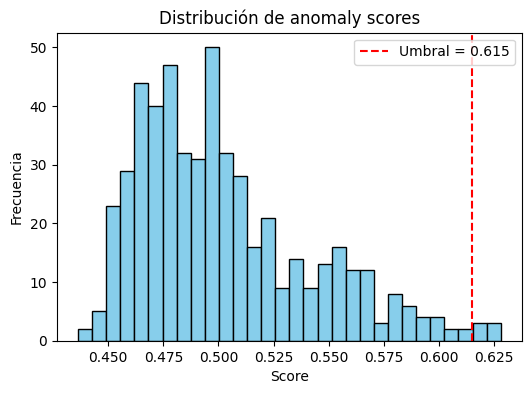

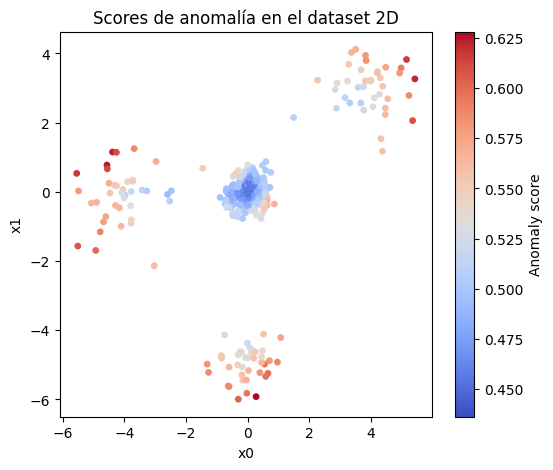

In [19]:
# Entrenamos de nuevo el bosque sobre X_demo
forest = IsolationForest(n_trees=50, sample_size=128, split_selection_random=False, contamination=0.01)
forest.fit(X_demo)

# Calculamos los scores
scores = forest.anomaly_score(X_demo)

# Histograma de scores
plt.figure(figsize=(6,4))
plt.hist(scores, bins=30, color="skyblue", edgecolor="black")
plt.axvline(forest.threshold_, color="red", linestyle="--", label=f"Umbral = {forest.threshold_:.3f}")
plt.title("Distribución de anomaly scores")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# Scatter plot coloreado por score
plt.figure(figsize=(6,5))
plt.scatter(X_demo[:,0], X_demo[:,1], c=scores, cmap="coolwarm", s=15)
plt.colorbar(label="Anomaly score")
plt.title("Scores de anomalía en el dataset 2D")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()


### Método `predict`

El método `predict` transforma los *scores* en etiquetas binarias:
- **1 = anomalía** si el score ≥ umbral.
- **0 = normal** en caso contrario.

El umbral `τ` puede fijarse de dos formas:
- Automáticamente en `fit()` (dependiendo de `contamination`).
- Manualmente pasando un valor al argumento `threshold` de `predict`.


In [20]:
def _predict(self, X, threshold=None):
        X = np.asarray(X)
        tau = threshold if threshold is not None else self.threshold_
        return (self.anomaly_score(X) >= tau).astype(int)

setattr(IsolationForest, "predict", _predict)

#### Predicciones en el dataset sintético

Aplicamos `predict` a `X_demo` y visualizamos:
- Los puntos normales frente a los detectados como anómalos.

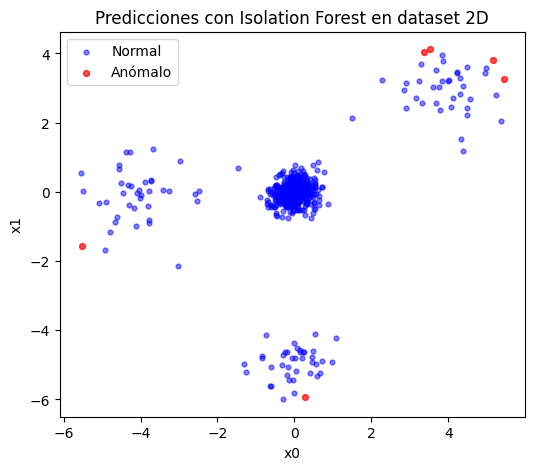

In [22]:
forest = IsolationForest(n_trees=50, sample_size=128, split_selection_random=False, contamination=0.01)
forest.fit(X_demo)

y_pred = forest.predict(X_demo)

# Scatter mostrando normales vs anomalías
plt.figure(figsize=(6,5))
plt.scatter(X_demo[y_pred==0,0], X_demo[y_pred==0,1], c="blue", s=12, alpha=0.5, label="Normal")
plt.scatter(X_demo[y_pred==1,0], X_demo[y_pred==1,1], c="red", s=18, alpha=0.7, label="Anómalo")
plt.title("Predicciones con Isolation Forest en dataset 2D")
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()
plt.show()

## Validación global en datasets reales

Usando nuestro pipeline de validación, lanzamos ahora los experimentos con **Isolation Forest** sobre varios datasets de referencia.  
El objetivo es explorar distintas configuraciones de hiperparámetros y comparar su rendimiento en cada conjunto.


In [1]:
import os
import pandas as pd
from modelos.IsolationForest import IsolationForest
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from runner import run_dataset_experiment

# 1. Configuración global
datasets = ["BATADAL", "SKAB", "WADI", "EbayRanSynCoders", "SMAP", "MSL"]

metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

# Grid de hiperparámetros incluyendo n_jobs para activar el paralelismo
param_grid_iforest = {
    "n_trees": [50, 100],
    "sample_size": [64, 128, 256],
    "split_selection_random": [True, False],
    "contamination": [0.01, 0.05, 0.1],
    "n_jobs": [-1]   # usa todos los cores
}

# 2. Lanzar experimentos
results_all = {}
summary_rows = []

for ds in datasets:
    df_results, topk, df_final = run_dataset_experiment(
        dataset_name=ds,
        model_class=IsolationForest,
        param_grid=param_grid_iforest,
        metrics=metrics,
        params_cv={"num_windows": 10},
        mode="tscv",
        sort_metric="nab",
        top_k=5,
        plot_mode="none"  # cambia a "none" para ejecuciones batch rápidas
    )
    
    results_all[ds] = {
        "grid": df_results,
        "topk": topk,
        "final": df_final
    }
    
    # Resumen rápido para comparar datasets
    best_row = df_final.iloc[df_final["nab"].idxmax()]
    summary_rows.append({
        "dataset": ds,
        "best_nab": best_row["nab"],
        "best_f1": best_row["f1"],
        "best_prec": best_row["precision"],
        "best_recall": best_row["recall"]
    })

summary_df = pd.DataFrame(summary_rows)
print("\n=== Resumen de mejores resultados por dataset (Isolation Forest) ===")
print(summary_df)


🏁 Ejecutando experimento en dataset: BATADAL
[✓] DATA cargado desde D:\TFG\TFG\Avance\MDF-ANOMALY-DETECTION\modelos\data\BATADAL\data.parquet (12938 filas)
   - Train: 8761 filas
   - Val:   2506 filas
   - Test:  1671 filas


Grid search:   0%|          | 0/36 [04:47<?, ?config/s]


KeyboardInterrupt: 

## 🧪 Validación experimental de Isolation Forest Básico

Para evaluar el rendimiento de nuestro **Isolation Forest implementado desde cero**, seguimos el mismo protocolo definido en PCA:

1. **Partición temporal**: generamos una serie sintética con anomalías inyectadas y dividimos en *train*, *val* y *test*. Unimos **train+val** para la búsqueda de hiperparámetros y reservamos **test** para la evaluación final.
2. **Validación con TSCV**: utilizamos un **Time Series Cross-Validation** con ventanas deslizantes (parámetros `P_train`, `num_windows`, etc.) para respetar la causalidad temporal y evitar *look-ahead*.
3. **Preprocesado consistente**: aplicamos el mismo pipeline de preprocesado (detección/mitigación de outliers con filtro de Hampel, tratamiento estacional si procede y normalización) que en el resto de modelos, para asegurar comparaciones justas.
4. **Búsqueda de hiperparámetros**: realizamos un *grid search* sobre:
   - `n_trees`: número de árboles del bosque.
   - `sample_size`: tamaño de muestra por árbol (valores fijos como 256, fracciones del dataset o usar todos los datos).
   - `contamination`: proporción esperada de anomalías, que se usa para fijar el umbral interno de decisión.
5. **Métricas**: calculamos **precision**, **recall**, **F1**, **ROC-AUC**, **NAB** y **window coverage**. Seleccionamos las 5 mejores configuraciones de validación según **NAB**.
6. **Evaluación final**: reentrenamos las configuraciones *top-5* en **train+val** y medimos en **test**. Para cada configuración mostramos la curva ROC y la visualización de anomalías detectadas frente a anomalías reales en las señales.

> Nota: en esta implementación, el parámetro `contamination` controla el **umbral de decisión** a partir del score de aislamiento. Valores altos hacen que el modelo detecte más anomalías (mayor *recall*, menor *precision*), mientras que valores bajos producen un modelo más conservador. El grid permite encontrar el equilibrio más adecuado para nuestro problema.


In [1]:
# ==========================
# 0. Imports
# ==========================
import pandas as pd
from utils import generate_synthetic_timeseries
from modelos.IsolationForest import IsolationForest 
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from runner import run_experiment

# ==========================
# 1. Generar datos sintéticos
# ==========================
df_train, df_val, df_test = generate_synthetic_timeseries(
    n=1000, train_ratio=0.4, val_ratio=0.3, anomaly_ratio=0.06, seed=42
)

df_trainval = pd.concat([df_train, df_val], ignore_index=True)
X_trainval, y_trainval = df_trainval[["f1", "f2", "f3"]], df_trainval["anomaly"]
X_test, y_test = df_test[["f1", "f2", "f3"]], df_test["anomaly"]

# ==========================
# 2. Definir métricas
# ==========================
metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

# ==========================
# 3. Definir grid de hiperparámetros
# ==========================
param_grid_if = {
    "n_trees": [100, 200, 300],
    "sample_size": [128, 256, 512],
    "contamination": [0.02, 0.05, 0.1, 0.2],
    "split_selection_random": [True]   
}

# ==========================
# 4. Ejecutar experimento
# ==========================
df_results, top5, df_final = run_experiment(
    model_class=IsolationForest,
    param_grid=param_grid_if,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    X_test=X_test,
    y_test=y_test,
    metrics=metrics,
    params_cv={"P_train": 0.4, "num_windows": 15},  
    mode="tscv",
    sort_metric="nab",  
    top_k=5,
)


Grid search:   8%|▊         | 3/36 [00:08<01:33,  2.83s/config]


KeyboardInterrupt: 

## 🔀 Variante de división basada en valores reales

En el experimento anterior se utilizó la política tradicional de división en los nodos del bosque:  
- Se selecciona un atributo al azar.  
- Se escoge un punto de corte de forma **uniforme** entre el mínimo y el máximo de dicha característica.  

Esta estrategia es eficiente, pero puede introducir cortes poco representativos cuando los datos están muy concentrados en determinadas zonas, ya que se fuerzan divisiones en regiones donde no hay observaciones.

Para abordar esta limitación, proponemos una variante en la construcción de los árboles:  
- En lugar de muestrear el punto de corte de forma uniforme en \[min, max\], se selecciona **un valor real de la muestra** para definir la división.  
- De esta manera, cada corte se realiza exactamente en un punto presente en los datos, lo que puede conducir a árboles más ajustados a la distribución real y, en algunos casos, a una mejor capacidad de aislamiento de anomalías sutiles.

En la implementación, esta diferencia está controlada por el parámetro:

- `split_selection_random=True` → política clásica (min–max).  
- `split_selection_random=False` → política basada en valores reales de la muestra.  

A continuación repetiremos la validación experimental empleando esta segunda variante, manteniendo el resto del pipeline idéntico, para comparar sus resultados con la versión tradicional.


In [1]:
# ==========================
# 0. Imports
# ==========================
import pandas as pd
from utils import generate_synthetic_timeseries
from modelos.IsolationForest import IsolationForest 
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from runner import run_experiment

# ==========================
# 1. Generar datos sintéticos
# ==========================
df_train, df_val, df_test = generate_synthetic_timeseries(
    n=1000, train_ratio=0.4, val_ratio=0.3, anomaly_ratio=0.06, seed=42
)

df_trainval = pd.concat([df_train, df_val], ignore_index=True)
X_trainval, y_trainval = df_trainval[["f1", "f2", "f3"]], df_trainval["anomaly"]
X_test, y_test = df_test[["f1", "f2", "f3"]], df_test["anomaly"]

# ==========================
# 2. Definir métricas
# ==========================
metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

# ==========================
# 3. Definir grid de hiperparámetros
# ==========================
param_grid_if = {
    "n_trees": [100, 200, 300],
    "sample_size": [128, 256, 512],
    "contamination": [0.02, 0.05, 0.1, 0.2],
    "split_selection_random": [False]
}

# ==========================
# 4. Ejecutar experimento
# ==========================
df_results, top5, df_final = run_experiment(
    model_class=IsolationForest,
    param_grid=param_grid_if,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    X_test=X_test,
    y_test=y_test,
    metrics=metrics,
    params_cv={"P_train": 0.4, "num_windows": 15},  
    mode="tscv",
    sort_metric="nab",  
    top_k=5,
    plot_mode="best" 
)


Grid search:   6%|▌         | 2/36 [00:08<02:28,  4.38s/config]


KeyboardInterrupt: 

## 📊 Comparación entre políticas de división en Isolation Forest

Tras ejecutar la validación con las dos variantes propuestas:

- **Método 1 – Política clásica**  
  Selección uniforme del umbral de corte en el rango \[min, max\] de cada característica.  

- **Método 2 – Política empírica**  
  Selección del umbral directamente de los **valores reales observados** en la muestra.  

hemos obtenido los siguientes resultados en el conjunto de datos sintéticos.

---

### 🔎 Resultados de validación

**Método 1 (clásico):**
- Mejores configuraciones presentan valores de **NAB en torno a 0.62–0.67** y **F1 entre 0.52–0.56**.  
- Tiende a mantener un buen **ROC-AUC (≈0.88–0.90)** y a equilibrar *precision* y *recall*.  
- Ejemplo: con `n_trees=200`, `sample_size=128` y `contamination=0.10` se alcanzó un **F1=0.563**, **NAB=0.646** y **window_cov=0.574**.

**Método 2 (empírico):**
- Destaca por un **mayor NAB**, alcanzando valores de **0.85–0.86** en las mejores configuraciones, lo que refleja una mejor cobertura temporal de las anomalías.  
- El **recall suele ser más alto**, lo que mejora la sensibilidad, aunque en algunos casos a costa de *precision* ligeramente inferior.  
- Ejemplo: con `n_trees=200`, `sample_size=256` y `contamination=0.10` se obtuvo un **F1=0.649**, **NAB=0.865** y **window_cov=0.608**.

---

### 📌 Discusión

La comparación muestra un patrón interesante:

- El **método clásico** ofrece estabilidad y un balance más “neutral” entre métricas, apoyado en un supuesto de uniformidad en los cortes.  
- El **método empírico**, al basarse en la distribución real de los datos, consigue cortes más representativos y logra **mejores puntuaciones NAB** y **mayor recall**, lo que indica que detecta un rango más amplio de anomalías en las series temporales.  
- Sin embargo, también aparecen casos con *precision* muy alta pero *recall* bajo (p. ej. precision=1.0, recall=0.216), lo que sugiere que la política empírica puede ser más sensible a la configuración de hiperparámetros.




## 📌 Conclusiones del Capítulo 6 – Isolation Forest

En este capítulo se ha profundizado en la aplicación de **Isolation Forest** para la detección de anomalías en series temporales, desde sus fundamentos teóricos hasta su validación experimental bajo distintas configuraciones.

Los principales hallazgos pueden resumirse en:

1. **Robustez del modelo:**  
   Isolation Forest se ha mostrado como un algoritmo eficiente y flexible, capaz de detectar anomalías sin necesidad de supuestos estadísticos ni etiquetas previas.  
   Su naturaleza no supervisada y el bajo coste computacional lo convierten en un buen candidato para la exploración inicial de anomalías en datos multivariados.

2. **Importancia del umbral de decisión:**  
   El parámetro `contamination` resultó clave para balancear **precision** y **recall**.  
   - Valores bajos producen un modelo más conservador (menos falsos positivos, pero riesgo de no detectar anomalías).  
   - Valores altos aumentan la sensibilidad, aunque a costa de más falsos positivos.  
   El grid search permitió ajustar este compromiso según el criterio temporal **NAB**.

3. **Nuevas variantes de partición:**  
   - La **política clásica** (elección uniforme en \[min, max\]) mostró un rendimiento equilibrado, con **ROC-AUC alto** y un buen balance entre métricas.  
   - La **política empírica** (elección del punto de corte entre valores reales de la muestra) mejoró notablemente las métricas temporales (**NAB** y **window coverage**) y elevó el **recall**, mostrando un mejor ajuste a la distribución real de los datos.

4. **Limitaciones observadas:**  
   A pesar de los buenos resultados, Isolation Forest presenta dificultades para detectar **anomalías relacionales** (violaciones de dependencias físicas entre variables), ya que trabaja principalmente sobre la distribución marginal de los valores.  
   Además, la variante empírica mostró casos extremos con *precision* muy alta pero *recall* reducido, lo que subraya su dependencia en una correcta selección de hiperparámetros.

---

### 🌱 Próximos pasos

Tras haber completado la validación de PCA (capítulo 5) y de Isolation Forest (capítulo 6), avanzaremos ahora hacia el siguiente modelo, el **One-Class SVM**.  



## Referencias

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou.  
**"Isolation forest."** 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

Aquí empieza el experimento de un ISOLATION FOREST Brutalmente rápido:

Definir el grid de hiperparámetros

In [ ]:
from modelos.IsolationForest import IsolationForest
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)

metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_coverage": window_coverage_metric,
}

param_grid = {
    "n_trees": [50, 100],
    "sample_size": [128, 256],
    "contamination": [0.001, 0.005, 0.01, 0.05, 0.1],
    "split_selection_random": [True],
}


Iniciamos cluster de Dask en GPU y corremos experimento

Cluster Dask en GPU inicializado
<Client: 'tcp://127.0.0.1:44583' processes=1 threads=1, memory=49.02 GiB>
🏁 Ejecutando experimento en dataset: BATADAL
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/BATADAL/data.parquet (12938 filas)
   - Train: 8761 filas
   - Val:   2506 filas
   - Test:  1671 filas


Evaluación en test: 100%|██████████| 2/2 [00:13<00:00,  6.88s/it]

Top 2 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
0,0.036,0.111,0.054,0.499,0.178,0.108,50,128,0.01,True
6,0.052,0.167,0.079,0.551,0.175,0.171,100,128,0.01,True


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
0,0.185,0.043,0.069,0.748,0.310,0.032,50,128,0.01,True
1,0.182,0.034,0.058,0.685,0.308,0.061,100,128,0.01,True


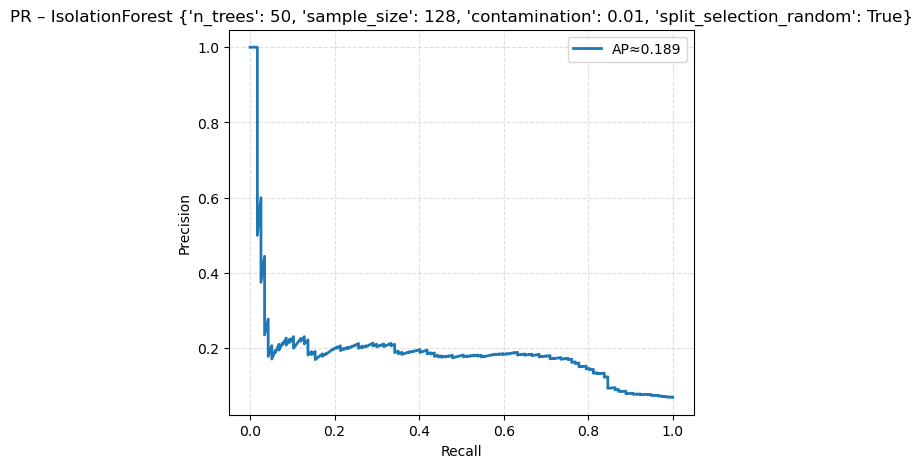

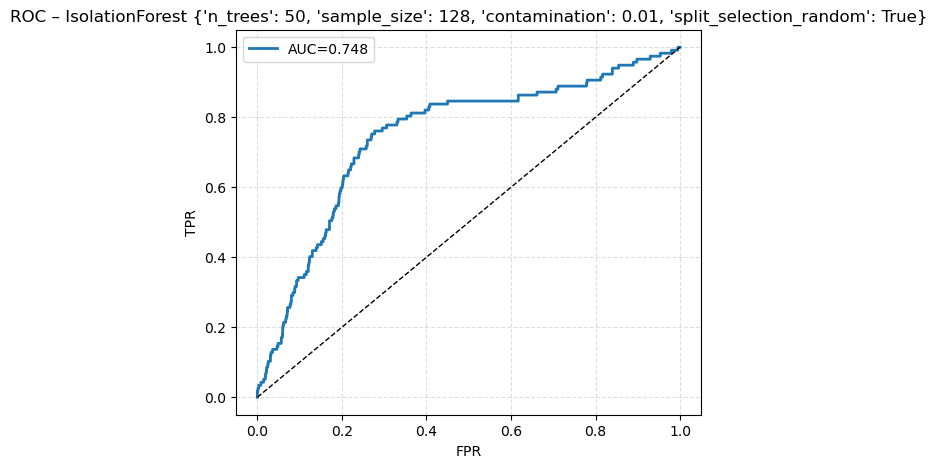

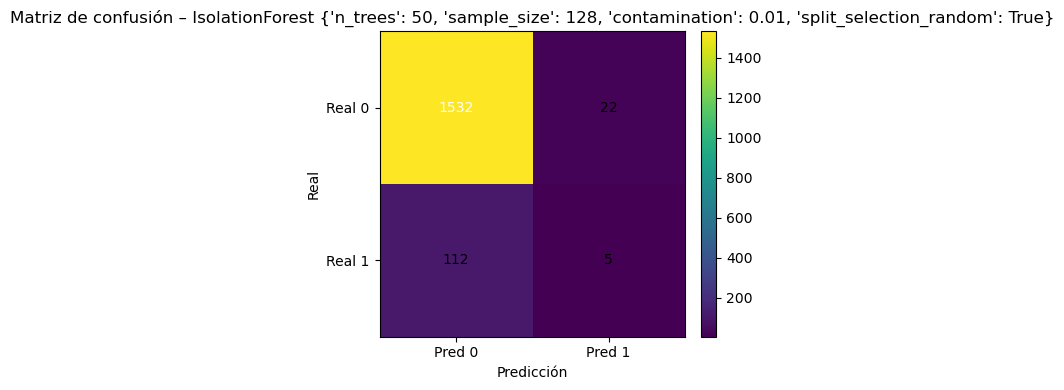

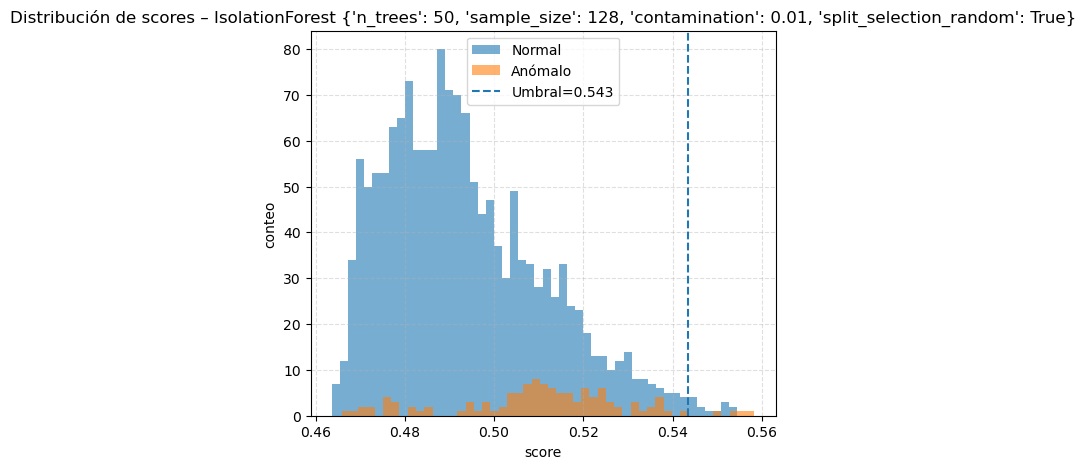

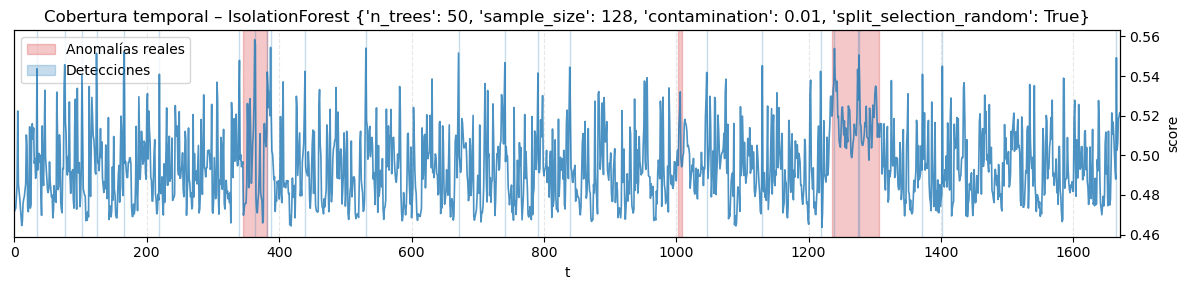

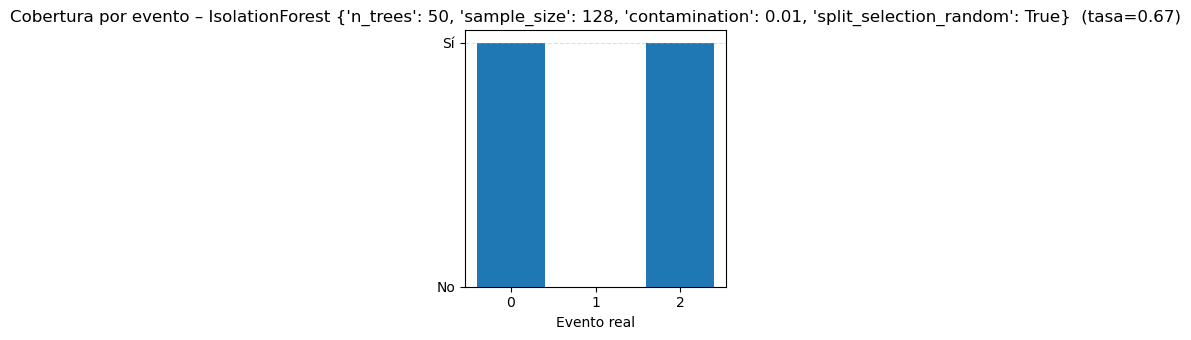

In [2]:
import warnings
warnings.filterwarnings("ignore", message="Cannot get CPU affinity")

from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)

print("Cluster Dask en GPU inicializado")
print(client)
# Dashboard: http://127.0.0.1:8787


from runner import run_dataset_experiment

df_results, topk, df_final = run_dataset_experiment(
    dataset_name="BATADAL",
    model_class=IsolationForest,
    param_grid=param_grid,
    metrics=metrics,
    params_cv={"num_windows": 3},   # reduce al inicio para que vaya rápido
    mode="tscv",
    hampel_cfg={"window": 25, "sigma": 5.0},
    top_k=2,
    sort_metric="nab",
    plot_mode="best"
)

